# Multi-Objective Optimization - 101

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/Multi_objective_optimization_101.ipynb)

In this tutorial, we will explore how to run black-box multi-objective optimization (MOO). In this setting, the goal is to resolve the following problem:

$$ \text{max}_x (f_0(x), f_1(x), ..., f_n(x)) $$

where $x$ is the set of optimized variables and $f_i$ are the different objectives. In DeepHyper, we use scalarization to transform such multi-objective problem into a single-objective problem:

$$ \text{max}_x s_w((f_0(x), f_1(x), ..., f_n(x))) $$

where $w$ is a set of weights which manages the trade-off between objectives and $s_w : \mathbb{R}^n \rightarrow \mathbb{R}$. The weight vector $w$ is randomized and re-sampled for each new batch of suggestion from the optimizer.



In [1]:
# Installing DeepHyper if not present
try:
    import deephyper
    print(deephyper.__version__)
except (ImportError, ModuleNotFoundError):
    !pip install deephyper

# Installing DeepHyper/Benchmark if not present
try:
    import deephyper_benchmark as dhb
except (ImportError, ModuleNotFoundError):
    !pip install -e "git+https://github.com/deephyper/benchmark.git@main#egg=deephyper-benchmark"

0.5.0


We will look at the DTLZ benchmark suite, a classic in multi-objective optimization (MOO) litterature. This benchmark exibit some characteristic cases of MOO. By default, this tutorial is loading the DTLZ-II benchmark which exibit a Pareto-Front with a concave shape.

In [2]:
import os

n_objectives = 2

# Configuration of the DTLZ Benchmark
os.environ["DEEPHYPER_BENCHMARK_DTLZ_PROB"] = str(2)
os.environ["DEEPHYPER_BENCHMARK_NDIMS"] = str(3)
os.environ["DEEPHYPER_BENCHMARK_NOBJS"] = str(n_objectives)
os.environ["DEEPHYPER_BENCHMARK_DTLZ_OFFSET"] = str(0.6)
os.environ["DEEPHYPER_BENCHMARK_FAILURES"] = str(0)

# Loading the DTLZ Benchmark
import deephyper_benchmark as dhb; dhb.load("DTLZ");
from deephyper_benchmark.lib.dtlz import hpo, metrics

2023-07-21 15:20:14.345774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can display the variable search space of the benchmark we just loaded:

In [3]:
hpo.problem

Configuration space object:
  Hyperparameters:
    x0, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x1, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x2, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

To define a black-box for multi-objective optimization it is very similar to single-objective optimization at the difference that the `objective` can now be a list of values. A first possibility is:


```python
def run(job):
    ...
    return objective_0, objective_1, ..., objective_n
```

which just returns the objectives to optimize as a tuple. If additionnal metadata are interesting to gather for each evaluation it is also possible to return them by following this format:

```python
def run(job):
    ...
    return {
        "objective": [objective_0, objective_1, ..., objective_n],
        "metadata": {
            "flops": ...,
            "memory_footprint": ...,
            "duration": ...,
        }
    }
```
each of the metadata needs to be JSON serializable and will be returned in the final results with a column name formatted as `m:metadata_key` such as `m:duration`.

Now we can load Centralized Bayesian Optimization search:

In [4]:
from deephyper.search.hps import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback

In [6]:
# Interface to submit/gather parallel evaluations of the black-box function.
# The method argument is used to specify the parallelization method, in our case we use threads.
# The method_kwargs argument is used to specify the number of workers and the callbacks.
# The TqdmCallback is used to display a progress bar during the search.
evaluator = Evaluator.create(
    hpo.run,
    method="thread",
    method_kwargs={"num_workers": 4, "callbacks": [TqdmCallback()]},
)

# Search algorithm
# The acq_func argument is used to specify the acquisition function.
# The multi_point_strategy argument is used to specify the multi-point strategy,
# in our case we use qUCB instead of the default cl_max (constant-liar) to reduce overheads.
# The update_prior argument is used to specify whether the sampling-prior should
# be updated during the search.
# The update_prior_quantile argument is used to specify the quantile of the lower-bound
# used to update the sampling-prior.
# The moo_scalarization_strategy argument is used to specify the scalarization strategy.
# Chebyshev is capable of generating a diverse set of solutions for non-convex problems.
# The moo_scalarization_weight argument is used to specify the weight of the scalarization.
# random is used to generate a random weight vector for each iteration.
search = CBO(
    hpo.problem,
    evaluator,
    acq_func="UCB",
    multi_point_strategy="qUCB",
    update_prior=True,
    update_prior_quantile=0.25,
    moo_lower_bounds=[-0.5, None],
    moo_scalarization_strategy="Chebyshev",
    moo_scalarization_weight="random",
    objective_scaler="quantile-uniform",
    verbose=1,
)

# Launch the search for a given number of evaluations
# other stopping criteria can be used (e.g. timeout, early-stopping/convergence)
results = search.search(max_evals=1000)

/Users/tyler/Git/deephyper/deephyper/evaluator/_evaluator.py:127: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

A Pandas table of results is returned by the search and also saved at `./results.csv`. An other location can be specified by using `CBO(..., log_dir=...)`.

In [7]:
results

,p:x0,p:x1,p:x2,objective_0,objective_1,job_id,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,pareto_efficient
0,0.803330,0.478756,0.255738,-0.344541,-1.079570,0,0.195520,0.197421,1.689971e+09,1.689971e+09,False
1,0.621787,0.311213,0.564836,-0.607134,-0.898788,3,0.195617,0.225188,1.689971e+09,1.689971e+09,False
2,0.692956,0.285571,0.073445,-0.638277,-1.219149,2,0.195592,0.225817,1.689971e+09,1.689971e+09,False
3,0.631865,0.561962,0.800726,-0.569384,-0.872364,1,0.195562,0.226416,1.689971e+09,1.689971e+09,False
4,0.439834,0.097888,0.311710,-1.029032,-0.850837,7,0.276708,0.278120,1.689971e+09,1.689971e+09,False
...,...,...,...,...,...,...,...,...,...,...,...
995,0.691516,0.538704,0.474111,-0.474957,-0.902226,994,137.786180,137.788268,1.689971e+09,1.689971e+09,False
996,0.688751,0.770774,0.536095,-0.485279,-0.912198,997,138.465000,138.465962,1.689971e+09,1.689971e+09,False
997,0.683875,0.604270,0.615239,-0.476530,-0.879443,998,138.465018,138.466569,1.689971e+09,1.689971e+09,False
998,0.683875,0.604270,0.615239,-0.476530,-0.879443,999,138.465033,138.466892,1.689971e+09,1.689971e+09,False


In this table we retrieve:

- columns starting by `p:` which are the optimized variables.
- the `objective_{i}` are the objectives returned by the black-box function.
- the `job_id` is the identifier of the executed evaluations.
- columns starting by `m:` are metadata returned by the black-box function.
- `pareto_efficient` is a column only returned for MOO which specify if the evaluation is part of the set of optimal solutions.

Let us use this table to visualized evaluated objectives:

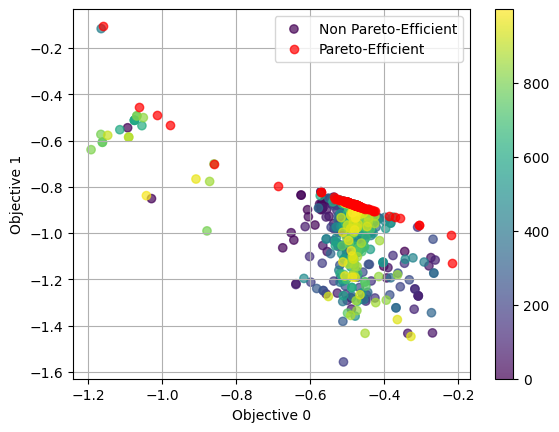

In [8]:
import matplotlib.pyplot as plt

results = results[results["objective_0"] != "F"]
results["objective_0"] = results["objective_0"].astype(float)
results["objective_1"] = results["objective_1"].astype(float)

plt.figure()
plt.scatter(
    results[~results["pareto_efficient"]]["objective_0"],
    results[~results["pareto_efficient"]]["objective_1"],
    marker="o",
    # color="blue",
    c=results[~results["pareto_efficient"]]["job_id"],
    alpha=0.7,
    label="Non Pareto-Efficient",
)
plt.plot(
    results[results["pareto_efficient"]]["objective_0"],
    results[results["pareto_efficient"]]["objective_1"],
    "o",
    color="red",
    alpha=0.7,
    label="Pareto-Efficient",
)
plt.colorbar()
plt.grid()
plt.legend()
plt.xlabel("Objective 0")
plt.ylabel("Objective 1")
plt.show()

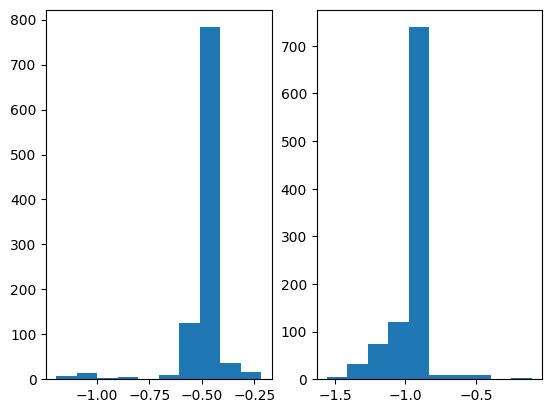

In [9]:
plt.figure()
plt.subplot(1, 2, 1)
plt.hist(results["objective_0"], bins=10)
plt.subplot(1, 2, 2)
plt.hist(results["objective_1"], bins=10)
plt.show()